# Read data

Mild Dementia: 5002 images
Moderate Dementia: 488 images
Non Demented: 67222 images
Very mild Dementia: 13709 images


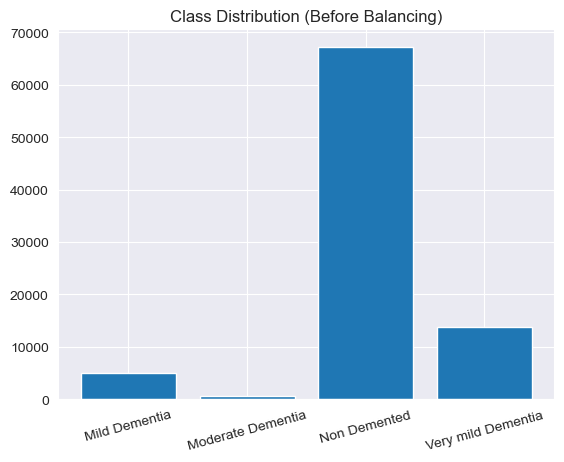

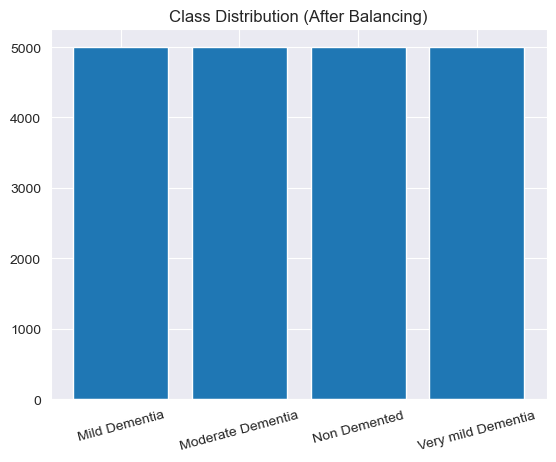

✅ Train size: 14000
✅ Validation size: 3000
✅ Test size: 3000


In [2]:
import os, glob
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# ----------------------------
# CONFIG
# ----------------------------
dataset_dir = r"C:\Users\diogo\OneDrive\Documents\MEIA\AAUT2IA\data"
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]
target_per_class = 5000

# ----------------------------
# Load image paths and labels
# ----------------------------
image_paths, labels = [], []
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    files = glob.glob(f"{class_dir}/*.jpg")
    print(f"{class_name}: {len(files)} images")
    image_paths.extend(files)
    labels.extend([idx] * len(files))

# ----------------------------
# EDA Before Balancing
# ----------------------------
def plot_class_distribution(labels, title):
    counts = Counter(labels)
    plt.bar(classes, [counts[i] for i in range(len(classes))])
    plt.title(title)
    plt.xticks(rotation=15)
    plt.show()

plot_class_distribution(labels, "Class Distribution (Before Balancing)")

# ----------------------------
# Preprocessing Function
# ----------------------------
def preprocess_image(image_path, augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.image.rgb_to_grayscale(image)

    image_uint8 = tf.cast(image * 255.0, tf.uint8)
    equalized = tf.numpy_function(cv2.equalizeHist, [tf.squeeze(image_uint8)], tf.uint8)
    equalized = tf.expand_dims(equalized, axis=-1)

    image_rgb = tf.image.grayscale_to_rgb(equalized)
    image_rgb = tf.cast(image_rgb, tf.float32) / 255.0

    if augment:
        image_rgb = tf.image.random_flip_left_right(image_rgb)
        image_rgb = tf.image.random_brightness(image_rgb, max_delta=0.05)
        image_rgb = tf.image.random_contrast(image_rgb, 0.95, 1.05)
        angle = tf.random.uniform([], -0.17, 0.17)
        image_rgb = tfa.image.rotate(image_rgb, angles=angle, fill_mode='reflect')
        image_rgb = tf.clip_by_value(image_rgb, 0.0, 1.0)

    return image_rgb

# ----------------------------
# Balanced Sampling
# ----------------------------
balanced_list = []
for class_id in range(len(classes)):
    class_paths = [p for p, l in zip(image_paths, labels) if l == class_id]
    count = len(class_paths)

    if count >= target_per_class:
        sampled = np.random.choice(class_paths, target_per_class, replace=False)
    else:
        oversample_factor = target_per_class - count
        sampled = class_paths + list(np.random.choice(class_paths, oversample_factor, replace=True))

    balanced_list.extend([(path, class_id) for path in sampled])

# ----------------------------
# Validate images & convert to tensors
# ----------------------------
valid_balanced_list = []
for path, label in balanced_list:
    try:
        img_tensor = preprocess_image(path, augment=False)
        img_np = img_tensor.numpy()
        if img_np.shape == (128, 128, 3) and not np.isnan(img_np).any():
            valid_balanced_list.append((img_np, label))
    except Exception as e:
        print(f"Skipping invalid image {path}: {e}")

# ----------------------------
# EDA After Balancing
# ----------------------------
balanced_labels = [lbl for _, lbl in valid_balanced_list]
plot_class_distribution(balanced_labels, "Class Distribution (After Balancing)")

# ----------------------------
# Train / Val / Test Split
# ----------------------------
np.random.seed(42)
np.random.shuffle(valid_balanced_list)

total = len(valid_balanced_list)
train_data = valid_balanced_list[:int(0.7 * total)]
val_data   = valid_balanced_list[int(0.7 * total):int(0.85 * total)]
test_data  = valid_balanced_list[int(0.85 * total):]

train_images, train_labels = zip(*train_data)
val_images, val_labels     = zip(*val_data)
test_images, test_labels   = zip(*test_data)

# ----------------------------
# TF Datasets
# ----------------------------
train_ds = tf.data.Dataset.from_tensor_slices((np.stack(train_images), np.array(train_labels)))
val_ds   = tf.data.Dataset.from_tensor_slices((np.stack(val_images),   np.array(val_labels)))
test_ds  = tf.data.Dataset.from_tensor_slices((np.stack(test_images),  np.array(test_labels)))

train_ds = train_ds.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Final Dataset Size Report
# ----------------------------
print(f"✅ Train size: {len(train_images)}")
print(f"✅ Validation size: {len(val_images)}")
print(f"✅ Test size: {len(test_images)}")

# Balance the dataset

# Data Agumentation

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras import regularizers

def create_cnn(input_shape=(128, 128, 3), num_classes=4):
    l2 = regularizers.l2(0.001)

    model = Sequential([
        Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2, input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(256, kernel_regularizer=l2),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [4]:
# Create the model
cnn_model = create_cnn()

# Print model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1

In [5]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True,
        monitor='val_loss'
    ),

    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        save_best_only=True,
        monitor='val_loss'
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
]

history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
219/219 [==============================] - 19s 61ms/step - loss: 2.2297 - accuracy: 0.4821 - val_loss: 3.8336 - val_accuracy: 0.2530 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 13s 58ms/step - loss: 1.7748 - accuracy: 0.6039 - val_loss: 2.3369 - val_accuracy: 0.2653 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 13s 59ms/step - loss: 1.5313 - accuracy: 0.6449 - val_loss: 1.4626 - val_accuracy: 0.6547 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 13s 58ms/step - loss: 1.4009 - accuracy: 0.6619 - val_loss: 1.4110 - val_accuracy: 0.6387 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 13s 58ms/step - loss: 1.3711 - accuracy: 0.6749 - val_loss: 1.3477 - val_accuracy: 0.6817 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 12s 56ms/step - loss: 1.3502 - accuracy: 0.6853 - val_loss: 1.4006 - val_accuracy: 0.6413 - lr: 0.0010
Epoch 7/100
219/219 [==============================]

In [6]:
cnn_model.save('optimized_cnn_v2.h5')

In [7]:
val_loss, val_acc = cnn_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")


47/47 [==============================] - 1s 17ms/step - loss: 0.7086 - accuracy: 0.8113
Validation Accuracy: 0.8113


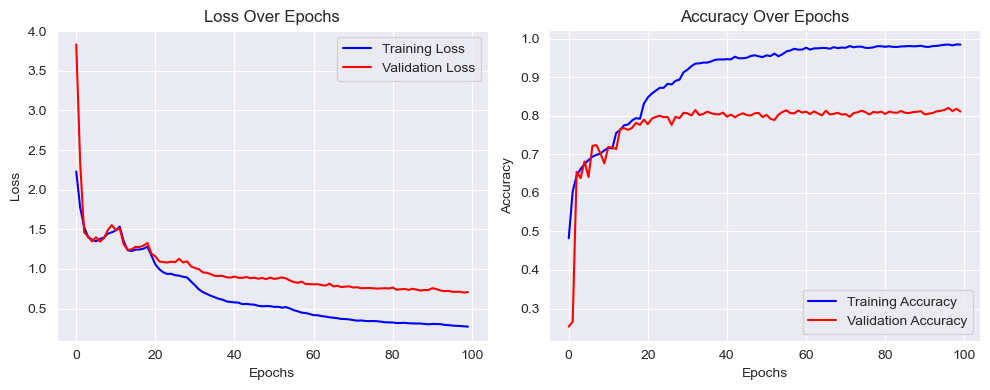

In [8]:
import matplotlib.pyplot as plt

def plot_loss_curves(model_history):
    """Plot training & validation loss and accuracy curves from history object."""

    if not model_history or not hasattr(model_history, "history"):
        print("Invalid history object.")
        return

    # Extract values safely
    loss = model_history.history.get('loss', [])
    val_loss = model_history.history.get('val_loss', [])
    accuracy = model_history.history.get('accuracy', [])
    val_accuracy = model_history.history.get('val_accuracy', [])

    epochs = range(len(loss))

    # Plot loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_curves(history)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_performance(model, val_ds, class_names, model_name="Model"):
    """
    Evaluate a trained model and show confusion matrix, accuracy, and classification report.

    Parameters:
        model (tf.keras.Model): Trained model to evaluate.
        val_ds (tf.data.Dataset): Validation dataset (batched).
        class_names (list): List of class names.
        model_name (str): Optional label for the plots and title.
    """
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # Classification report
    print(f"📊 {model_name} - Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"✅ {model_name} - Validation Accuracy: {acc:.4f}")


<Figure size 800x600 with 0 Axes>

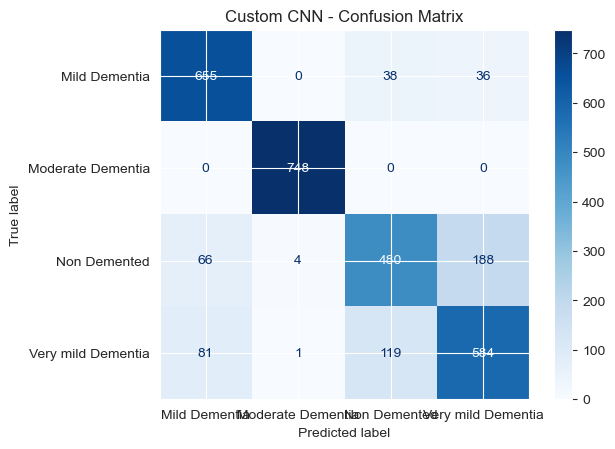

📊 Custom CNN - Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia       0.82      0.90      0.86       729
 Moderate Dementia       0.99      1.00      1.00       748
      Non Demented       0.75      0.65      0.70       738
Very mild Dementia       0.72      0.74      0.73       785

          accuracy                           0.82      3000
         macro avg       0.82      0.82      0.82      3000
      weighted avg       0.82      0.82      0.82      3000

✅ Custom CNN - Validation Accuracy: 0.8223


In [10]:
evaluate_model_performance(cnn_model, test_ds, classes, model_name="Custom CNN")

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_resnet50(num_classes=4):
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    base.trainable = False

    inputs = Input(shape=(128, 128, 3))
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [12]:
from tensorflow.keras.applications import Xception

def build_xception(num_classes=4):
    base = Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    base.trainable = False

    inputs = Input(shape=(128, 128, 3))
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet(num_classes=4):
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    base.trainable = False

    inputs = Input(shape=(128, 128, 3))
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
model_resnet50 = build_resnet50()

history = model_resnet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
    ]
)

Epoch 1/100
219/219 [==============================] - 14s 52ms/step - loss: 1.5056 - accuracy: 0.2434 - val_loss: 1.3934 - val_accuracy: 0.2777
Epoch 2/100
219/219 [==============================] - 11s 49ms/step - loss: 1.4446 - accuracy: 0.2523 - val_loss: 1.3860 - val_accuracy: 0.2503
Epoch 3/100
219/219 [==============================] - 11s 50ms/step - loss: 1.4216 - accuracy: 0.2645 - val_loss: 1.3820 - val_accuracy: 0.2737
Epoch 4/100
219/219 [==============================] - 11s 50ms/step - loss: 1.4064 - accuracy: 0.2610 - val_loss: 1.3819 - val_accuracy: 0.2767
Epoch 5/100
219/219 [==============================] - 12s 55ms/step - loss: 1.4009 - accuracy: 0.2636 - val_loss: 1.3812 - val_accuracy: 0.3527
Epoch 6/100
219/219 [==============================] - 13s 59ms/step - loss: 1.3959 - accuracy: 0.2636 - val_loss: 1.3802 - val_accuracy: 0.3983
Epoch 7/100
219/219 [==============================] - 12s 54ms/step - loss: 1.3901 - accuracy: 0.2659 - val_loss: 1.3811 - val_ac

<Figure size 800x600 with 0 Axes>

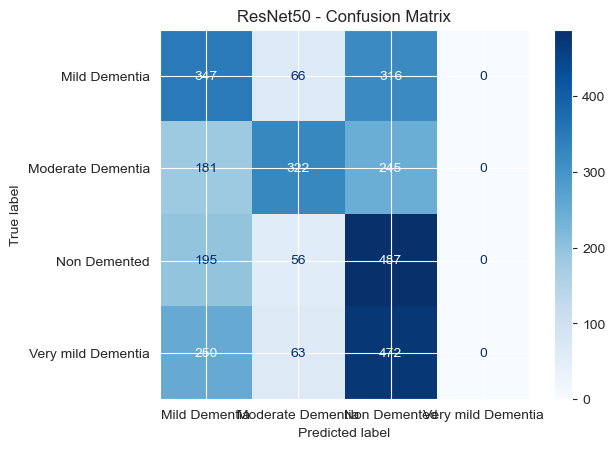

📊 ResNet50 - Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia       0.36      0.48      0.41       729
 Moderate Dementia       0.64      0.43      0.51       748
      Non Demented       0.32      0.66      0.43       738
Very mild Dementia       0.00      0.00      0.00       785

          accuracy                           0.39      3000
         macro avg       0.33      0.39      0.34      3000
      weighted avg       0.32      0.39      0.33      3000

✅ ResNet50 - Validation Accuracy: 0.3853


C:\Users\diogo\miniconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\diogo\miniconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\diogo\miniconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
evaluate_model_performance(model_resnet50, test_ds, classes, model_name="ResNet50")

In [16]:
model_xception = build_xception()

history_xception = model_xception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("xception_best.h5", save_best_only=True)
    ]
)


Epoch 1/100
219/219 [==============================] - 12s 48ms/step - loss: 1.3755 - accuracy: 0.3409 - val_loss: 1.2402 - val_accuracy: 0.4073
Epoch 2/100
219/219 [==============================] - 10s 45ms/step - loss: 1.2627 - accuracy: 0.3878 - val_loss: 1.2056 - val_accuracy: 0.4313
Epoch 3/100
219/219 [==============================] - 10s 45ms/step - loss: 1.2290 - accuracy: 0.4111 - val_loss: 1.1860 - val_accuracy: 0.4410
Epoch 4/100
219/219 [==============================] - 10s 46ms/step - loss: 1.2096 - accuracy: 0.4191 - val_loss: 1.1734 - val_accuracy: 0.4587
Epoch 5/100
219/219 [==============================] - 10s 45ms/step - loss: 1.1884 - accuracy: 0.4330 - val_loss: 1.1608 - val_accuracy: 0.4663
Epoch 6/100
219/219 [==============================] - 10s 44ms/step - loss: 1.1794 - accuracy: 0.4401 - val_loss: 1.1473 - val_accuracy: 0.4683
Epoch 7/100
171/219 [======================>.......] - ETA: 1s - loss: 1.1683 - accuracy: 0.4497

KeyboardInterrupt: 

<Figure size 800x600 with 0 Axes>

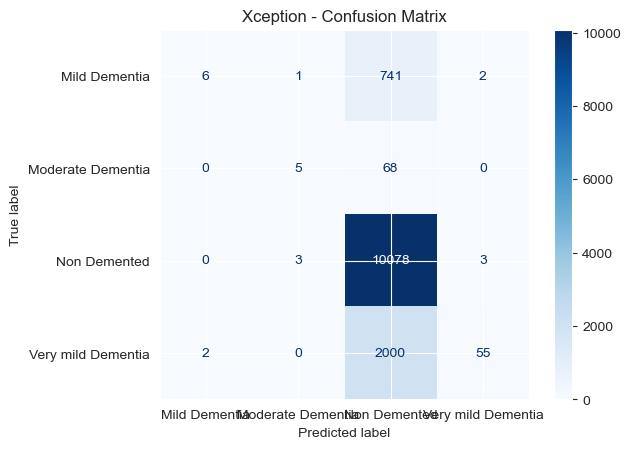

📊 Xception - Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia       0.75      0.01      0.02       750
 Moderate Dementia       0.56      0.07      0.12        73
      Non Demented       0.78      1.00      0.88     10084
Very mild Dementia       0.92      0.03      0.05      2057

          accuracy                           0.78     12964
         macro avg       0.75      0.28      0.27     12964
      weighted avg       0.80      0.78      0.69     12964

✅ Xception - Validation Accuracy: 0.7825


In [74]:
evaluate_model_performance(model_xception, test_ds, classes, model_name="Xception")


In [75]:
model_efficientnet = build_efficientnet()

history_efficientnet = model_efficientnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath="efficientnetb0_best_weights.h5",
            save_best_only=True,
            save_weights_only=True  # 🔧 Fix: only weights, no serialization problem
        )
    ]
)


Epoch 1/100
946/946 [==============================] - 120s 109ms/step - loss: 0.7108 - accuracy: 0.7749 - val_loss: 0.6822 - val_accuracy: 0.7778
Epoch 2/100
946/946 [==============================] - 116s 108ms/step - loss: 0.6955 - accuracy: 0.7778 - val_loss: 0.6851 - val_accuracy: 0.7778
Epoch 3/100
946/946 [==============================] - 116s 107ms/step - loss: 0.6914 - accuracy: 0.7778 - val_loss: 0.6821 - val_accuracy: 0.7778
Epoch 4/100
946/946 [==============================] - 115s 106ms/step - loss: 0.6916 - accuracy: 0.7778 - val_loss: 0.6829 - val_accuracy: 0.7778
Epoch 5/100
946/946 [==============================] - 118s 109ms/step - loss: 0.6909 - accuracy: 0.7778 - val_loss: 0.6833 - val_accuracy: 0.7778
Epoch 6/100
946/946 [==============================] - 116s 108ms/step - loss: 0.6886 - accuracy: 0.7778 - val_loss: 0.6823 - val_accuracy: 0.7778
Epoch 7/100
946/946 [==============================] - 117s 108ms/step - loss: 0.6889 - accuracy: 0.7778 - val_loss: 0

<Figure size 800x600 with 0 Axes>

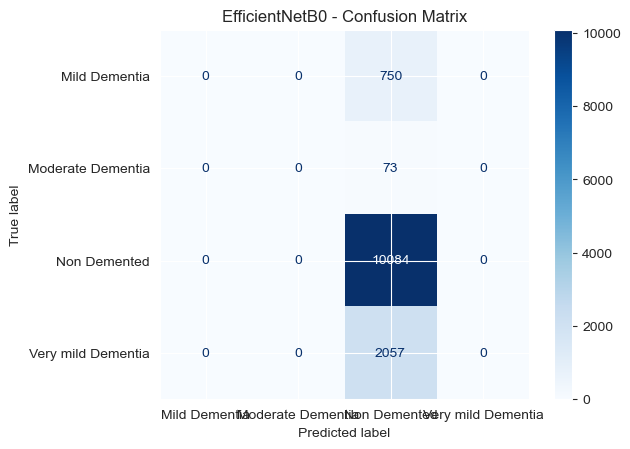

📊 EfficientNetB0 - Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia       0.00      0.00      0.00       750
 Moderate Dementia       0.00      0.00      0.00        73
      Non Demented       0.78      1.00      0.88     10084
Very mild Dementia       0.00      0.00      0.00      2057

          accuracy                           0.78     12964
         macro avg       0.19      0.25      0.22     12964
      weighted avg       0.61      0.78      0.68     12964

✅ EfficientNetB0 - Validation Accuracy: 0.7778


C:\Users\diogo\miniconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\diogo\miniconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\diogo\miniconda3\envs\tf210\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
evaluate_model_performance(model_efficientnet, test_ds, classes, model_name="EfficientNetB0")